In this first step, we will import the necessary libraries and load our Garmin running data from a CSV file. This file contains metrics recorded from multiple laps of a run. We'll preview the data to ensure it loaded correctly and start thinking about which columns are relevant for analysis.📘

## 📊 First Look at Our Parkrun Data

Let's see what secrets our parkrun data holds! We're loading data from multiple parkruns around Australia, each with their own unique vibes and challenges. Watch for those elevation differences - they're gonna be spicy! 🌶️

In [ ]:
# import some basic libraries for Exploratory Data Analysis
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for jupyter inline plots
%matplotlib inline

# load then view the data
sheet_data = pd.read_excel("parkrun_data_sample.xlsx", sheet_name=None)

parkrun_dfs = {}
for sheet_name, df in sheet_data.items():
    df_clean = df.iloc[:-1]  # drop last row
    parkrun_dfs[sheet_name] = df_clean

# Show which runs were loaded
print("Loaded parkruns:", list(parkrun_dfs.keys()))

# Preview one of the runs (e.g., first one)
parkrun_dfs[list(parkrun_dfs.keys())[3]].head()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

Loaded parkruns: ['brisbane_parkrun', 'centennial_parkrun', 'rhodes_parkrun', 'parramatta_parkrun', 'mosman_parkrun']


,Laps,Time,Cumulative Time,Distancekm,Avg Pacemin/km,Avg GAPmin/km,Avg HRbpm,Max HRbpm,Total Ascentm,Total Descentm,...,Avg Vertical Oscillationcm,Avg Vertical Ratio%,CaloriesC,Avg Temperature,Best Pacemin/km,Max Run Cadencespm,Moving Time,Avg Moving Pacemin/km,Avg Step Speed Losscm/s,Avg Step Speed Loss Percent%
0,1,00:04:59.500000,00:04:59.500000,1.0,04:59:00,05:04:00,135,155,1,1,...,9.9,7.9,71,NaN,04:27:00,169,04:57:00,04:57:00,NaN,NaN
1,2,00:05:00.700000,10:00:00,1.0,05:01:00,04:57:00,161,165,8,1,...,10.1,8.0,84,NaN,04:55:00,163,00:05:00.700000,05:01:00,NaN,NaN
2,3,00:05:09.800000,15:10:00,1.0,05:10:00,05:08:00,161,169,1,4,...,10.3,7.9,88,NaN,04:13:00,167,05:00:00,05:00:00,NaN,NaN
3,4,00:05:05.400000,20:15:00,1.0,05:05:00,05:07:00,166,169,0,5,...,10.3,8.1,87,NaN,04:44:00,159,00:05:05.400000,05:05:00,NaN,NaN
4,5,00:05:07.600000,"1 day, 1:23:00",1.0,05:08:00,05:07:00,167,170,2,0,...,10.2,8.1,88,NaN,04:36:00,161,05:07:00,05:07:00,NaN,NaN


## 🔄 First Lap vs Last Lap Showdown

Time to compare how we started vs how we finished! We'll look at:
* ⏱️ Lap times
* 💪 Power output
* 🦿 Running cadence

This will show us if we're starting too fast or pacing like a pro!

In [41]:
# Store results in a list of dicts
lap_comparisons = []

for name, df in parkrun_dfs.items():
    # Get first and last row
    first_lap = df.iloc[0]
    last_lap = df.iloc[-1]

    lap_comparisons.append({
        'Run': name,
        'First Lap Time': first_lap['Time'],
        'Last Lap Time': last_lap['Time'],
        'First Lap Max Power': first_lap['Max PowerW'],
        'Last Lap Max Power': last_lap['Max PowerW'],
        'Max Cadence first': first_lap['Max Run Cadencespm'],
        'Max Cadence last': last_lap['Max Run Cadencespm'],
    })

# Convert to DataFrame for comparison
comparison_df = pd.DataFrame(lap_comparisons)

# Show comparison
comparison_df


,Run,First Lap Time,Last Lap Time,First Lap Max Power,Last Lap Max Power,Max Cadence first,Max Cadence last
0,brisbane_parkrun,00:05:54.500000,00:05:06.800000,482,468,165,161
1,centennial_parkrun,00:05:57.100000,00:00:08.800000,420,427,163,159
2,rhodes_parkrun,00:04:38.900000,00:00:05.300000,596,364,186,157
3,parramatta_parkrun,00:04:59.500000,00:00:08,473,431,169,157
4,mosman_parkrun,00:05:18.800000,00:00:03.300000,508,416,167,153


## ⚡ Power Analysis

Check out these power curves! Notice how the first lap usually shows higher power output - that's either enthusiasm or poor pacing (we've all been there!). The drop in the final lap? Totally normal, your body's just keeping it real! 😅

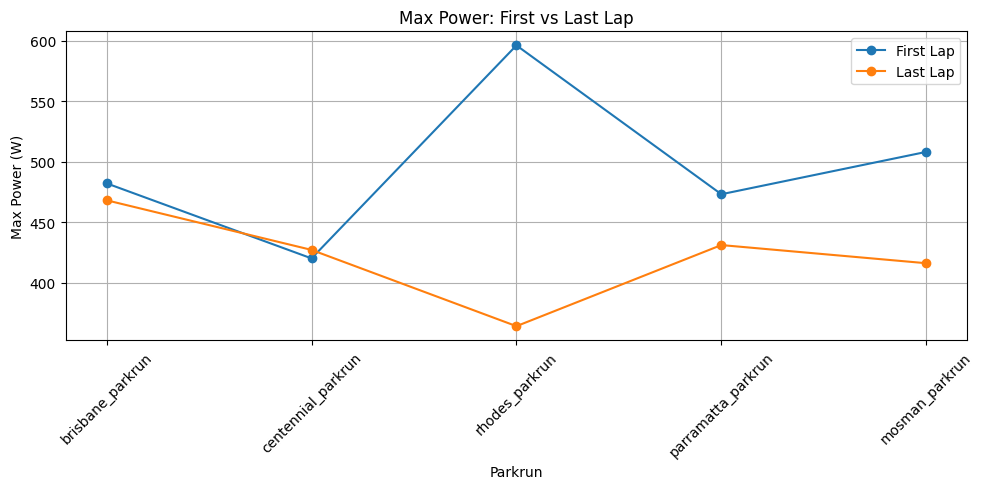

In [48]:
# Plot Max Power for First and Last Lap
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['Run'], comparison_df['First Lap Max Power'], marker='o', label='First Lap')
plt.plot(comparison_df['Run'], comparison_df['Last Lap Max Power'], marker='o', label='Last Lap')

plt.title("Max Power: First vs Last Lap")
plt.xlabel("Parkrun")
plt.ylabel("Max Power (W)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🎵 The Cadence Dance

Cadence is like your running rhythm - your personal parkrun beat! Most runners find their sweet spot between 150-160 steps per minute. Let's see who's dropping the fastest beats! 🎶

Pro tip: A steady cadence usually means better running economy!

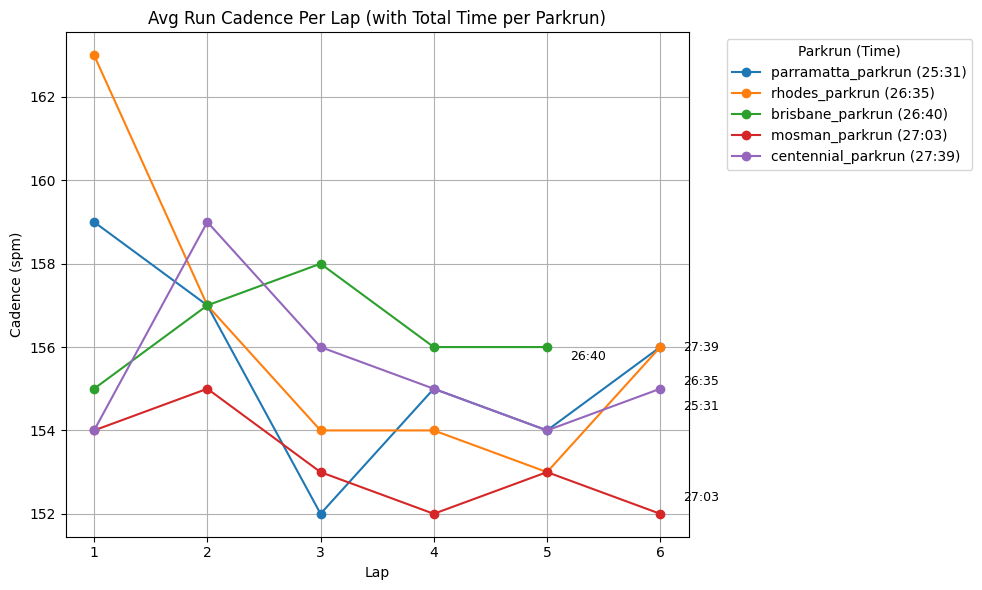

In [98]:
# Function to convert datetime.time to seconds
def time_to_seconds(t):
    return t.minute * 60 + t.second + t.microsecond / 1_000_000

# Store tuples of (run_name, df, total_time_in_seconds)
timed_runs = []
for run, df in parkrun_dfs.items():
    total_time = df["Time"].apply(time_to_seconds).sum()
    timed_runs.append((run, df, total_time))

# Sort runs by total time (ascending)
timed_runs.sort(key=lambda x: x[2])  # fastest first

# Plot cadence lines
plt.figure(figsize=(10, 6))

for i, (name, df, total_sec) in enumerate(timed_runs):
    laps = range(1, len(df) + 1)
    cadence = df["Avg Run Cadencespm"]

    # Plot cadence line
    plt.plot(laps, cadence, marker='o', label=f"{name} ({int(total_sec // 60)}:{int(total_sec % 60):02d})")

    # Label total time near end of line with vertical offset to avoid overlap
    offset = (i - len(timed_runs)/2) * 0.6
    plt.text(laps[-1] + 0.2, cadence.iloc[-1] + offset, f"{int(total_sec // 60)}:{int(total_sec % 60):02d}", fontsize=9)

# Final plot formatting
plt.title("Avg Run Cadence Per Lap (with Total Time per Parkrun)")
plt.xlabel("Lap")
plt.ylabel("Cadence (spm)")
plt.legend(title="Parkrun (Time)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🏔️ Elevation vs Speed: The Epic Battle

Now for the real talk - how much does elevation affect our times? Some parkruns are flat as a pancake, others... not so much! Let's see the relationship between climbing and running times.

Remember: More elevation = harder run = better training (but maybe not PB material!) 💯

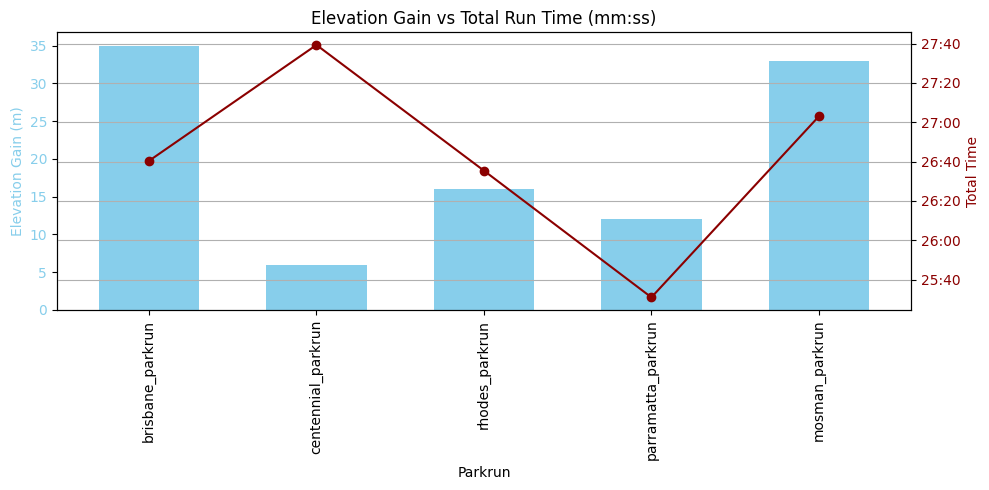

In [104]:
from matplotlib import ticker  # ✅ This line is required
# Formatter to convert seconds to mm:ss
def format_mmss(x, pos):
    minutes = int(x // 60)
    seconds = int(x % 60)
    return f"{minutes}:{seconds:02d}"

# Reuse elevation & time data
elev_stats = {}
time_stats = {}

def time_to_seconds(t):
    return t.minute * 60 + t.second + t.microsecond / 1_000_000

for run, df in parkrun_dfs.items():
    elev_stats[run] = df["Total Ascentm"].sum()
    total_time = df["Time"].apply(time_to_seconds).sum()
    time_stats[run] = total_time

elev_df = pd.DataFrame({
    "Total Ascent (m)": elev_stats,
    "Total Time (s)": time_stats
})

# Plot elevation bars
fig, ax1 = plt.subplots(figsize=(10, 5))
elev_df["Total Ascent (m)"].plot(kind='bar', ax=ax1, color='skyblue', width=0.6)
ax1.set_ylabel("Elevation Gain (m)", color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Plot total time as line with mm:ss formatting
ax2 = ax1.twinx()
line = ax2.plot(elev_df.index, elev_df["Total Time (s)"], color='darkred', marker='o', label="Run Time")
ax2.set_ylabel("Total Time", color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(format_mmss))

plt.title("Elevation Gain vs Total Run Time (mm:ss)")
ax1.set_xlabel("Parkrun")
plt.grid(True)
fig.tight_layout()
plt.show()


# 🏃‍♂️ Parkrun Analysis - The Spicy Details

### Power Moves 💪
* Rhodes parkrun came in hot with that first lap power spike (596W) - absolute unit!
* Most runners showed that classic power drop-off in the final lap (perfectly normal, bestie)

### Pace & Elevation Tea ⛰️
* Brisbane and Mosman = elevation demons (~35m climb)
* Parramatta parkrun = speed king (fastest overall time)
* Centennial taking it easy with that chill 6m elevation

### Cadence Chronicles 🦿
* Everyone's keeping it steady in that 150-160spm range
* Rhodes parkrun said "bet" with that 186spm first lap
* Most runners showing that textbook cadence fade (we love consistency)

### The TL;DR 📱
Different parkruns = different vibes. Brisbane/Mosman giving us that hill climb challenge, while Parramatta's serving speed goals. Your cadence might start enthusiastic but keeping it steady is the real MVP move.

Next time you're choosing your parkrun, remember:
* Want a flat sprint? → Centennial
* Need elevation gains? → Brisbane
* Looking for that PB life? → Parramatta

Stay hydrated, fam! 🌊